In [ ]:
"""Omid55"""

# Imports

In [1]:
#Omid55
import requests
import pandas as pd
import pickle as pk
import csv
import time
import numpy as np
import random
from collections import defaultdict
import seaborn as sns
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix
import networkx as nx
import glob
% matplotlib inline

# Useful Classes and Functions

In [14]:
def is_she_has_similar_history_in_stats_and_training(sid):
    d = 0
    for k in summoners_training[sid].champions.keys():
        if k in summoners_stats[sid].champions.keys():
            if summoners_training[sid].champions[k].get_win_ratio() > 0:
                d += abs(summoners_training[sid].champions[k].get_win_ratio() - summoners_stats[sid].champions[k].get_win_ratio())
    return d


# def is_she_has_similar_history_in_stats_and_training(sid):
#     # if there is at least 50% of training in the stats, we consider her as good
#     r = len(list(set(summoners_training[sid].champions.keys()) - set(summoners_stats[sid].champions.keys()))) / float(len(summoners_training[sid].champions.keys()))
#     return r < 0.5

(array([  2.56394000e+05,   3.74000000e+02,   1.17000000e+02,
          3.80000000e+01,   1.90000000e+01,   5.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          1.00000000e+00]),
 array([  0.        ,   2.14804175,   4.29608351,   6.44412526,
          8.59216701,  10.74020876,  12.88825052,  15.03629227,
         17.18433402,  19.33237578,  21.48041753]),
 <a list of 10 Patch objects>)

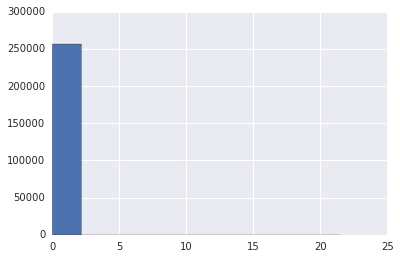

In [16]:
dist = []
for sid in summoners_training.keys():
    dist.append(is_she_has_similar_history_in_stats_and_training(sid))
plt.hist(dist)

In [3]:
"""Brief and useful info Match class"""
class Match:
    def __init__(self):
        self.summonerIds_championIds_isWinner_tier = []
        self.matchCreation = 0
        self.matchDuration = 0
        self.matchId = 0
        self.matchMode = ""
        self.matchType = ""
        
    def __init__(self, match):
        self.summonerIds_championIds_isWinner_tier = get_summonerIds_championIds_isWinner_tier(match)
        self.matchCreation = match['matchCreation']
        self.matchDuration = match['matchDuration']
        self.matchId = match['matchId']
        self.matchMode = match['matchMode']
        self.matchType = match['matchType']
        
    def __str__(self):
        return 'id:' + str(self.matchId) + ', mode:' + str(self.matchMode) + ', type:' + str(self.matchType) + ', creation:' + str(self.matchCreation) + ', duration:' + str(self.matchDuration) + ', my stats:' + str(self.summonerIds_championIds_isWinner_tier)
    

In [4]:
"""ChampionResult is a simple class with number of
    wins and loses as integer value"""
class ChampionResult:
    def __init__(self):
        self.wins = 0
        self.loses = 0
    
    def get_win_ratio(self):
        #assert self.wins + self.loses != 0, 'There is no matches available...'
        if not self.wins + self.loses:
            return 0
        return self.wins / float(self.wins + self.loses)
    
    def get_game_count(self):
        return self.wins + self.loses
        
        
"""SummonerChampionStats has a hashtable of champions which
    describes how many time summoner won or lost with that
    (GameResult as each item)"""
class SummonerChampionStats:
    def __init__(self):
        self.champions = defaultdict(lambda: ChampionResult())
    
    def get_game_count(self):
        return sum([c.get_game_count() for c in self.champions.values()])
    
    def get_win_ratio(self):
        w = sum([c.wins for c in self.champions.values()])
        l = sum([c.loses for c in self.champions.values()])
        #assert w + l != 0, 'There is no matches available...'
        if not w + l:
            return 0
        return w / float(w+l)
        
    def get_same_champion_game_count(self, champId):
        return self.champions[champId].get_game_count()
        
    def get_same_champion_win_ratio(self, champId):
        return self.champions[champId].get_win_ratio()
        

In [5]:
# preprocessing summoners from matches in order to have a dictionary of summoners with
#    a dictionary of their previous selected champions and GameResult for
#       for each selected champion (wins and loses)
def preprocess_given_matches(previous_matchIds_for_stats):
    summoners_stats = defaultdict(lambda: SummonerChampionStats())
    for mid in previous_matchIds_for_stats:
        summoner_champ_winner = matches[mid].summonerIds_championIds_isWinner_tier
        for s in summoner_champ_winner:
            if s[2]:
                summoners_stats[s[0]].champions[s[1]].wins += 1
            else:
                summoners_stats[s[0]].champions[s[1]].loses += 1
    return summoners_stats

Get the index for a sid in the network, it adds a new node if sid does not exist

In [6]:
def get_the_index_for_sid(sid):
    if sid not in sid_map:
        sid_map[sid] = len(sid_map)
    return sid_map[sid]

# in general format
def get_index_for(dictionary, val):
    if val not in dictionary:
        dictionary[val] = len(dictionary)
    return dictionary[val]

Get a list of network features for a given adjacency matrix

In [7]:
net_metric_names = ['AC', 'clustering', 'shortest_path_length', 'diameter', 'spectrum_v1', 'spectrum_v2', 'spectrum_v3', 'spectrum_v4', 'spectrum_v5']

def get_network_metrics(A):
    #nx.draw(A)
    return [nx.algebraic_connectivity(A), nx.average_clustering(A),
        nx.average_shortest_path_length(A) if nx.is_connected(A) else -1, 
            nx.diameter(A) if nx.is_connected(A) else -1] + list(nx.laplacian_spectrum(A))

# Loading the whole data

In [8]:
# loading all saved matches
matches = {}
for fname in glob.glob("MATCHES_till_sid*.pkl"):
    print(fname)
    with open(fname, 'rb') as f:
        matches_chunk = pk.load(f)    
        matches = dict(matches.items()+matches_chunk.items())   # adding all matches together

MATCHES_till_sid512106.pkl
MATCHES_till_sid503154.pkl
MATCHES_till_sid35050.pkl
MATCHES_till_sid31287.pkl
MATCHES_till_sid4698.pkl
MATCHES_till_sid33108.pkl
MATCHES_till_sid515669.pkl
MATCHES_till_sid504948.pkl
MATCHES_till_sid5502.pkl
MATCHES_till_sid37119.pkl
MATCHES_till_sid1039.pkl
MATCHES_till_sid6755.pkl
MATCHES_till_sid10139.pkl
MATCHES_till_sid8499.pkl
MATCHES_till_sid3410.pkl
MATCHES_till_sid1900.pkl
MATCHES_till_sid509003.pkl
MATCHES_till_sid7780.pkl
MATCHES_till_sid28766.pkl
MATCHES_till_sid514117.pkl
MATCHES_till_sid603363.pkl


In [21]:
print 'Length of all matches is', len(matches)

Length of all matches is 208711


# Separating the data to 3 parts: Stats, Training and Test Dataset

In [10]:
# selecting a sample of matches
SAMPLE_IT = False
if SAMPLE_IT:
    SAMPLE_SIZE = 10000
    sampled_matches_ids = [matches.keys()[s] for s in sorted(random.sample(range(len(matches)), SAMPLE_SIZE))]
else:  # all the data
    sampled_matches_ids = matches.keys()

# sorting matches with respect to their match creation date
dates = np.zeros(len(sampled_matches_ids))
for i, mid in enumerate(sampled_matches_ids):
    dates[i] = matches[mid].matchCreation
sampled_matches_ids_sorted = [x for (y,x) in sorted(zip(dates, sampled_matches_ids))]
#all(dates[i]<=dates[i+1] for i in range(len(dates)-1))  # for checking if this is sorted or no

# spliting the data to 70% for stats and 20% for training and 10% for testing 
stats_len = int(0.6*len(sampled_matches_ids_sorted))
training_len = int(0.2*len(sampled_matches_ids_sorted))
matchIds_for_stats = sampled_matches_ids_sorted[:stats_len]
matchIds_for_training_dataset = sampled_matches_ids_sorted[stats_len:stats_len+training_len]
matchIds_for_test_dataset = sampled_matches_ids_sorted[stats_len+training_len:]
print 'Length of matchIds_for_stats is\t\t\t', len(matchIds_for_stats), \
    '\nLength of matchIds_for_training_dataset is\t', len(matchIds_for_training_dataset), \
    '\nLength of matchIds_for_test_dataset is\t\t', len(matchIds_for_test_dataset)

Length of matchIds_for_stats is			125226 
Length of matchIds_for_training_dataset is	41742 
Length of matchIds_for_test_dataset is		41743


Preprocessing the summoners in the stats data

In [11]:
summoners_stats = preprocess_given_matches(matchIds_for_stats)
summoners_training = preprocess_given_matches(matchIds_for_training_dataset)

See if people in training dataset and stats have similar champion choices (distribution)

In [207]:
good_sids = []
for sid in summoners_training.keys():
    if is_she_has_similar_history_in_stats_and_training(sid):
        good_sids.append(sid)

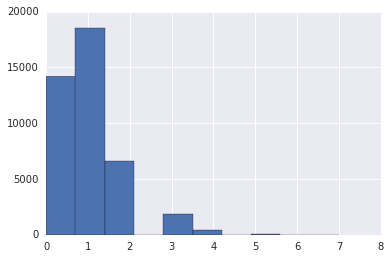

In [208]:
# Now we only consider those in the test set which are consisted of only good sids in their teams
cs = []
for mid in matchIds_for_test_dataset:
    sids = [m[0] for m in matches[mid].summonerIds_championIds_isWinner_tier]
    c = len(np.where(np.array([s in good_sids for s in sids]) == True)[0])
    cs.append(c)
plt.hist(cs);

# RUN FROM HERE

In [209]:
THRESHOLD = 4
selected_indices = np.where(np.array(cs)>=THRESHOLD)[0]
matchIds_for_test_dataset_selected = [matchIds_for_test_dataset[i] for i in selected_indices]

# building the dataset now:::
# for each match in the dataset
data = []
for mid in matchIds_for_test_dataset_selected:
    summoners_not_found_winner = 0
    summoners_not_found_loser = 0
    winners = []
    losers = []
    
    sc = matches[mid].summonerIds_championIds_isWinner_tier
    # for each member in each team
    for s in sc:
        stat = summoners_stats[s[0]]
        tmp = [
            stat.get_game_count(),
            stat.get_win_ratio(),
            stat.get_same_champion_game_count(s[1]),
            stat.get_same_champion_win_ratio(s[1])
        ]
        if s[2]:
            winners.append(tmp)
        else:
            losers.append(tmp)
       
        if not winners:
            sample = [0, 0]
        else:
            sample = list(np.average(winners, axis=0)) + \
                list(np.std(winners, axis=0))
        if not losers:
            sample += [0, 0]
        else:
            sample += list(np.average(losers, axis=0)) + \
            list(np.std(losers, axis=0))
    data.append(sample)

print 'Data length is', len(data)

# names for the features in the dataset
names = ['avg_game_count', 'avg_win_ratio', 'avg_same_champion_game_count', 'avg_same_champion_win_ratio', 
                     'std_game_count', 'std_win_ratio', 'std_same_champion_game_count', 'std_same_champion_win_ratio', 
                         'average_weight', 'std_weight'] + net_metric_names
feature_names = ['winner_' + na for na in names] + ['loser_' + na for na in names]

Data length is 577


In [210]:
dataset = pd.DataFrame(data=data, columns=['winner_avg_game_count', 'winner_avg_win_ratio', 'winner_avg_same_champion_game_count', 'winner_avg_same_champion_win_ratio', 
                                               'winner_std_game_count', 'winner_std_win_ratio', 'winner_std_same_champion_game_count', 'winner_std_same_champion_win_ratio', 
                                               'loser_avg_game_count', 'loser_avg_win_ratio', 'loser_avg_same_champion_game_count', 'loser_avg_same_champion_win_ratio', 
                                               'loser_std_game_count', 'loser_std_win_ratio', 'loser_std_same_champion_game_count', 'loser_std_same_champion_win_ratio' 
                                               ])

dataset.to_csv('Classification2016_Dataset_STAT_TRAIN_TEST_ratio_diff.csv')

Starting ...
Loaded data size:  (577, 17)
Swapping  8.0 : 16.0  with 0 : 8.0  ...
Dataset size:  (577, 17)
                                classifier  test acc  train acc
0                                      KNN     50.80      63.26
1          Quadratic Discriminant Analysis     53.57      61.41
2                            Decision Tree     49.93      69.59
3             Linear Discriminant Analysis     55.62      59.33
4                      SVM with RBF kernel     51.30      67.26
5                              Naive Bayes     55.97      58.50
6                               Linear SVM     55.62      59.33
7                            Random Forest     54.42      99.83
8   Stochastic Gradient Descent Classifier     51.46      51.32
9                                 AdaBoost     54.08      73.91
10                     Logistic Regression     56.14      59.21
11                         Dummy (Uniform)     53.03      49.10
Computing embedding
Done.
average : 0.14s
complete : 0.14s


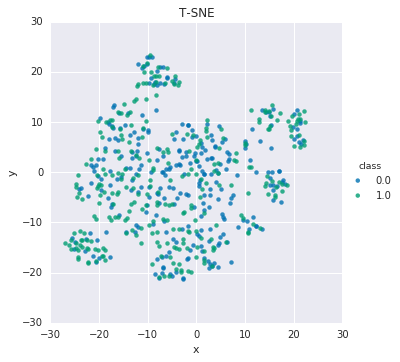

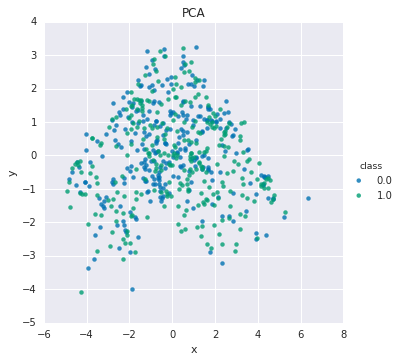

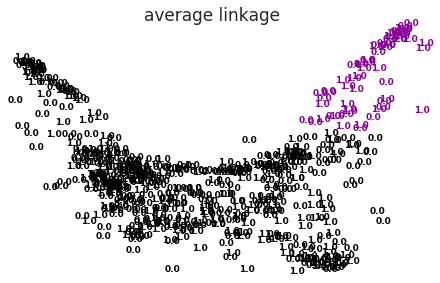

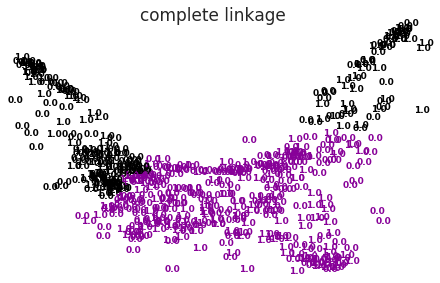

Computing embedding
Done.
average : 0.14s
complete : 0.14s


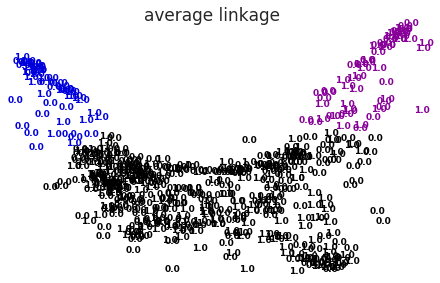

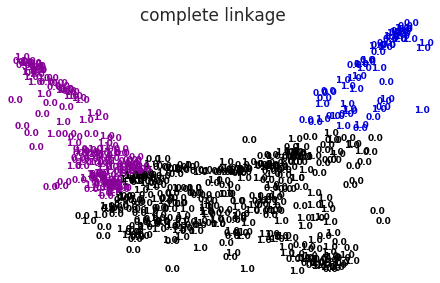

Computing embedding
Done.
average : 0.14s
complete : 0.14s


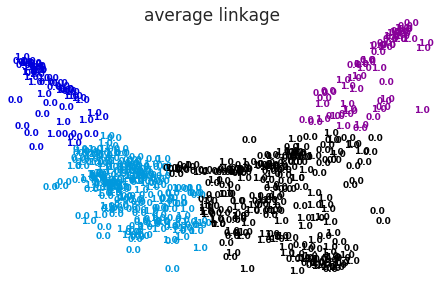

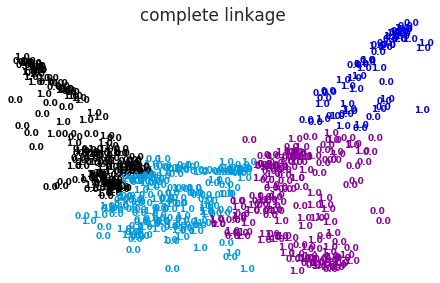

In [211]:
import classification_pipeline as pi
pi = reload(pi)
pi.run('Classification2016_Dataset_STAT_TRAIN_TEST_ratio_diff.csv')

Starting ...
Loaded data size:  (577, 17)
Swapping  8.0 : 16.0  with 0 : 8.0  ...
Dataset size:  (577, 17)
                                classifier  test acc  train acc
0                                      KNN     50.41      64.47
1          Quadratic Discriminant Analysis     51.81      64.57
2                            Decision Tree     49.37      72.25
3             Linear Discriminant Analysis     54.23      59.31
4                      SVM with RBF kernel     53.91      67.78
5                              Naive Bayes     55.81      59.23
6                               Linear SVM     54.23      59.37
7                            Random Forest     53.23      99.83
8   Stochastic Gradient Descent Classifier     50.10      52.13
9                                 AdaBoost     56.15      75.04
10                     Logistic Regression     54.23      58.98
11                         Dummy (Uniform)     53.21      48.59
Computing embedding
Done.
average : 0.15s
complete : 0.14s


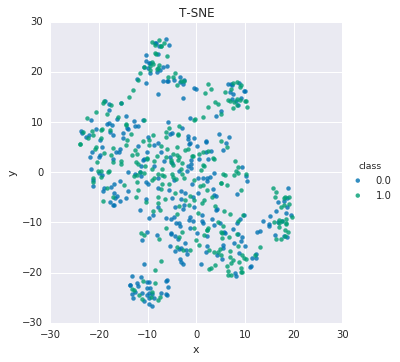

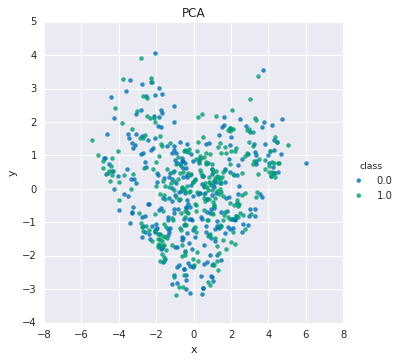

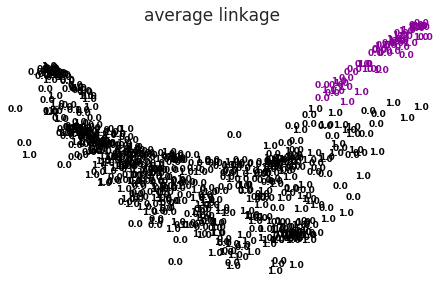

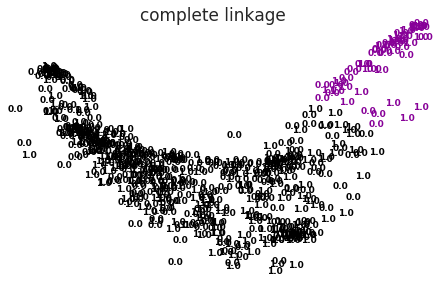

Computing embedding
Done.
average : 0.14s
complete : 0.14s


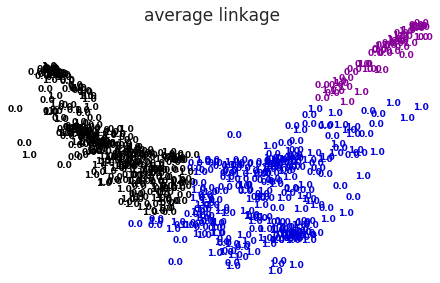

KeyboardInterrupt: 

In [212]:
pi.run('Classification2016_Dataset_STAT_TRAIN_TEST_ratio_diff.csv')